# Where should a drinks company run promotions?

**Background**

Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

**Importing packages**

In [168]:
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from math import dist

mpl.rcParams['figure.figsize'] = 8, 6
mpl.rcParams['font.size'] = 14

## First look on the data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.
Let's look at the first 5 rows.

In [169]:
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


According to the marketing team, the columns mean the following:

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

On the next step we will perform Exploratory data analysis (EDA).

## EDA

At first we should count the number of regions in the dataset.

In [170]:
df['region'].nunique()

85

85 regions, this is quite a lot of data to analyze!

Now let's plot overall consumption of alcohol by drink type in Saints Petersburg.

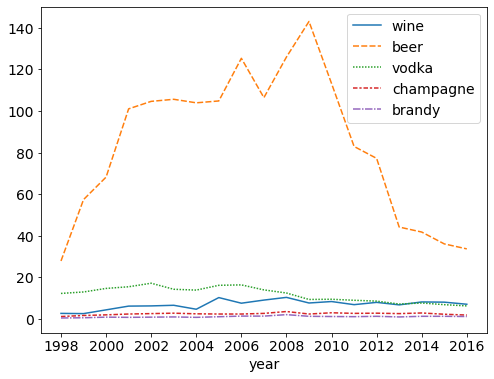

In [171]:
df_spb = df.query('region == "Saint Petersburg"').set_index('year').drop(columns=['region'])

sns.lineplot(data=df_spb)
plt.xticks(range(1998, 2017, 2))
plt.show()

So mostly people in Saint Petersburg do consume beer. Other' beverages consumption is lower, so it is hard to analyze.

We will replot the data but add a national mean consumption of those beverages.

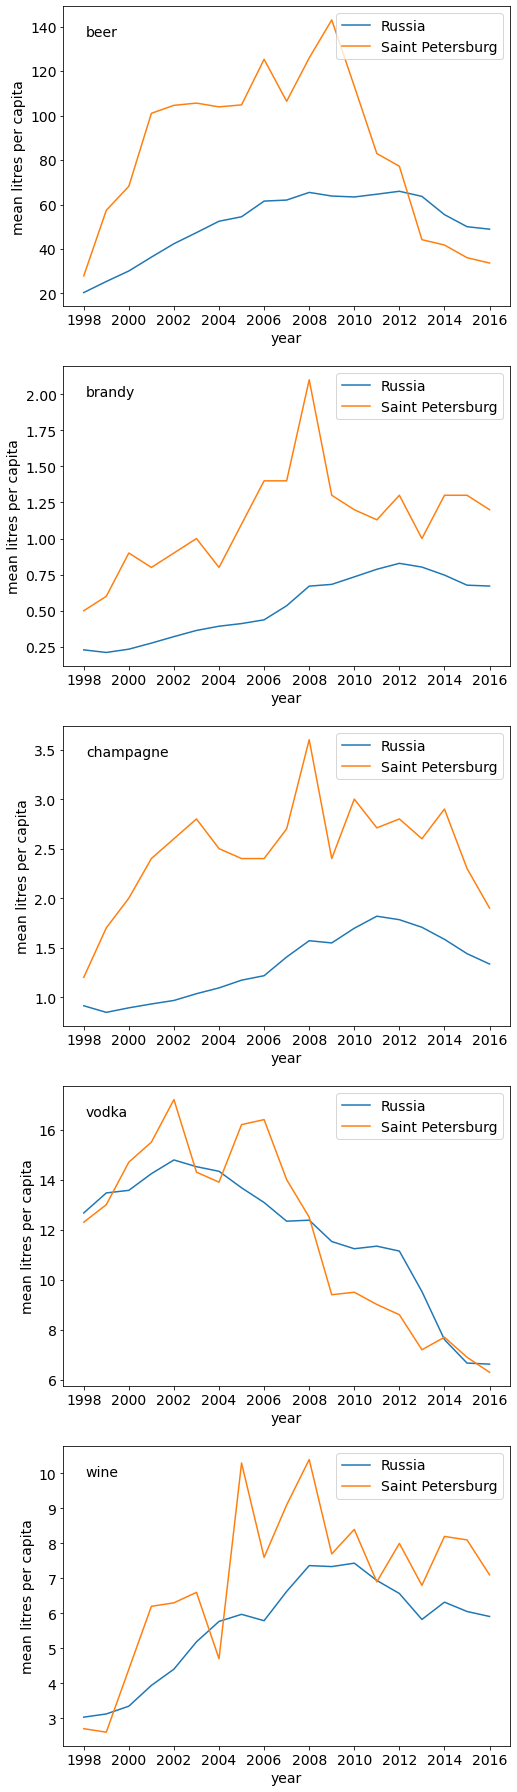

In [172]:
df_nat = pd.pivot_table(df, index='year', values=['wine', 'beer', 'vodka', 'champagne', 'brandy'], aggfunc='mean').reset_index()
columns_to_plot = df_nat.columns[1:]

fig, ax = plt.subplots(5, 1, figsize=(8, 32))
for i in range(len(columns_to_plot)):
    sns.lineplot(data=df_nat, x='year', y=columns_to_plot[i], ax=ax[i], label='Russia')
    sns.lineplot(data=df_spb, x='year', y=columns_to_plot[i], ax=ax[i], label='Saint Petersburg')
    ax[i].set_xticks(range(1998, 2017, 2))
    ax[i].text(0.05, 0.9, columns_to_plot[i], fontsize=14, transform=ax[i].transAxes)
    ax[i].set_ylabel('mean litres per capita')
    ax[i].legend(loc='upper right')

It can be seen that:
- Beer consumption in SPb is lower than the mean national one.
- In SPb they do consume more brandy, champagne and wine as compared with the mean consumption. 
- Consumption of vonda decreases in both Russia and SPb.

Therefore, for our further analysis we can:
- Drop some of the drinks, since there is an overall trand of consumption decrease.
- Reduce the number of years that we are interested in. Since we want to predict consumption in the future, we may want to use only the recent data for it.

On the next step we will handle data prepocessing and feature engineering

## Data preprocessing and feature engineering

### Data preprocessing

At first let's just include three last years in our analysis: 2014 - 2016.

In [173]:
df_14_16 = df.query('year >= 2014')

Now we should check for the missing values.

In [174]:
df_14_16.isna().sum()

year         0
region       0
wine         6
beer         1
vodka        6
champagne    6
brandy       6
dtype: int64

So there are 6 rows that do not include almost all the alcohol type. Let's check what are those regions.

In [175]:
df_14_16[df_14_16.isna().any(axis=1)]

,year,region,wine,beer,vodka,champagne,brandy
1377,2014,Republic of Ingushetia,NaN,0.4,NaN,NaN,NaN
1439,2014,Chechen Republic,NaN,4.9,NaN,NaN,NaN
1462,2015,Republic of Ingushetia,NaN,0.5,NaN,NaN,NaN
1524,2015,Chechen Republic,NaN,2.2,NaN,NaN,NaN
1547,2016,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
1609,2016,Chechen Republic,NaN,1.2,NaN,NaN,NaN


So there are two regions that have the alcohol consumption data only for beer. It is better that we exclude those regions.

In [176]:
regions_to_exclude = df_14_16[df_14_16.isna().any(axis=1)]['region'].unique()
df_14_16 = df_14_16.query('region not in @regions_to_exclude')

Let's save our unique regions just in case we need it later.

In [177]:
regions = df_14_16['region'].unique()

The next step will be feature engineering.

### Feature engineering

The next question is: what is the exact data that we should use for our analysis?

We need to make some features for drinks that will allow us group our regions somehow in the future.
I propose it to be :
- The mean value of the 2014-2016 consumption
- Standard deviation of the values 
- Overall consumption in 2014-2016
- Consumption in 2016
- Trend of the consumption change

In [180]:
def trend(x):
    return x.iloc[-1] / x.iloc[0]

df_grouped = df_14_16.drop(columns='year').groupby(['region']).agg(['mean', 'std', 'sum', 'last', trend])
df_grouped.columns = ['_'.join(col) for col in df_grouped.columns]

In the next step we will perform dimensionality reduction of the obtained dataset.

## Dimensionality reduction

In the previos step we generated a lot of features for each region.

We can count the exact number of features.

In [192]:
df_grouped.shape[1]

25

As we can see, there is 25 different features. But not all of them are actually relevant, so we can reduce our dimensionality by using Principal Component Analysis or PCA.

Let's create pipeline that first scales all the features and then reduces the data to 10 dimensions.

In [193]:
pipe = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=10))])
pipe.fit(df_grouped)

Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components=10))])

In order to visualise how much variance we do explained with each component, we need to extract the corresponding values from our PCA step in a pipeline.

In [201]:
explained_variance = pd.DataFrame({'components':range(10), 
                                   'explained variance':pipe["PCA"].explained_variance_ratio_,
                                   'total explained variance':pipe["PCA"].explained_variance_ratio_.cumsum()})

Let's plot our results as a barchart of the variance explained by each component and the lineplot of the cumulative sum of the variance explained.

<AxesSubplot:xlabel='components', ylabel='explained variance'>

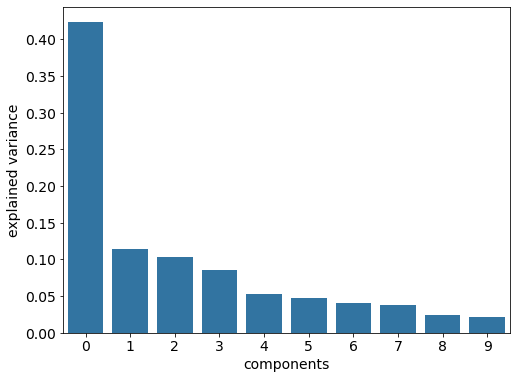

In [250]:
sns.barplot(x='components', y='explained variance', data=explained_variance, color='tab:blue')

<AxesSubplot:xlabel='components', ylabel='total explained variance'>

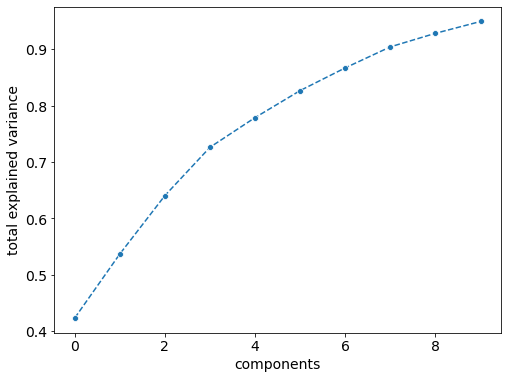

In [251]:
sns.lineplot(x='components', y='total explained variance', data=explained_variance, 
             linestyle='--', color='tab:blue', marker='o')

We can see, that our components do really explain most of the variance.

We can also check the exact number.

In [217]:
explained_variance['total explained variance'].values[-1].round(3)

0.95

So our 10 components explain 95% of the variation in data.

On the next step we will find the closest 10 regions to Saint Petersburg.

## Finding the nearest regions

In order to find the nearest regions it is proposed to calculate the Euclidian distance.

At the first step we should save our resulting dataframe with reduced dimensionality.

In [225]:
pca_df = pipe.transform(df_grouped)
pca_df = pd.DataFrame(pca_df, index=df_grouped.index, columns=['PC' + str(i) for i in range(1, 11)])

Now we will calculate the distances from each cluster to Saint Petersburg.

### Calculating the distance 

In [226]:
distances_to_spb = []

for region in regions:
    distances_to_spb.append(dist(pca_df.loc['Saint Petersburg'], pca_df.loc[region]))
    
distances_to_spb_df = pd.DataFrame({'distance':distances_to_spb}, index=regions)

Now let's sort the resulted dataframe and show the closesest regions to Saint Petersburg.

In [227]:
df_distances.sort_values(by='distance', ascending=True)[:11]

,distance
Saint Petersburg,0.000000
Novgorod Oblast,2.621397
Smolensk Oblast,2.650728
Chelyabinsk Oblast,3.044607
Leningrad Oblast,3.114681
Bryansk Oblast,3.122308
Perm Krai,3.283286
Oryol Oblast,3.436735
Novosibirsk Oblast,3.613075
Pskov Oblast,3.617024


On the next step we should visualise our results.

### Visualising the results

At the first step we should save our chosen regions.

In [224]:
chosen_regions = df_distances.sort_values(by='distance', ascending=True)[:11].index

It can be hard to visualise 10 components on one graph.

However, we saw that 3 components can explain around 70% of the variance of our data, so we can try to use only those.

We will plot PC1 on the x-axis, PC2 on the y-axis and PC3 as a size of our points.

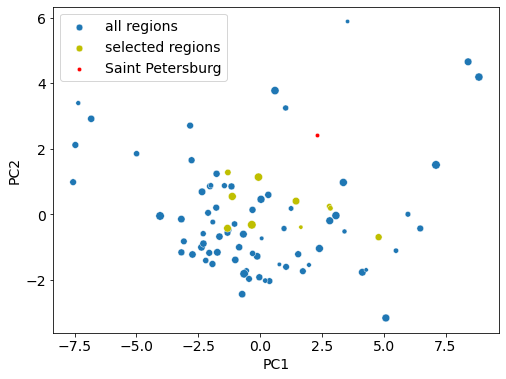

In [235]:
fig, ax = plt.subplots()
sns.scatterplot(data=pca_df.query('region not in @chosen_regions'), 
                x='PC1', y='PC2', size='PC3', ax=ax, label='all regions', legend=False)
sns.scatterplot(data=pca_df.query('region != "Saint Petersburg" and region in @chosen_regions'), 
                x='PC1', y='PC2', size='PC3', ax=ax, color='y', label='selected regions', legend=False)
sns.scatterplot(data=pca_df.query('region == "Saint Petersburg"'), color='r', 
                x='PC1', y='PC2', size='PC3', ax=ax, label='Saint Petersburg', legend=False)
ax.legend()

We can see that the selected regions are not exactly the closest ones, but they are still close.

But we should remember that we are using only 3 of the total 10 components, so maybe in higher dimensions they will be closer.

## Checking the selected regions

Lastly, we should plot the alcohol consumption for the regions that we selected and check whether the consumption habits are the same as for Saint Petersburg.

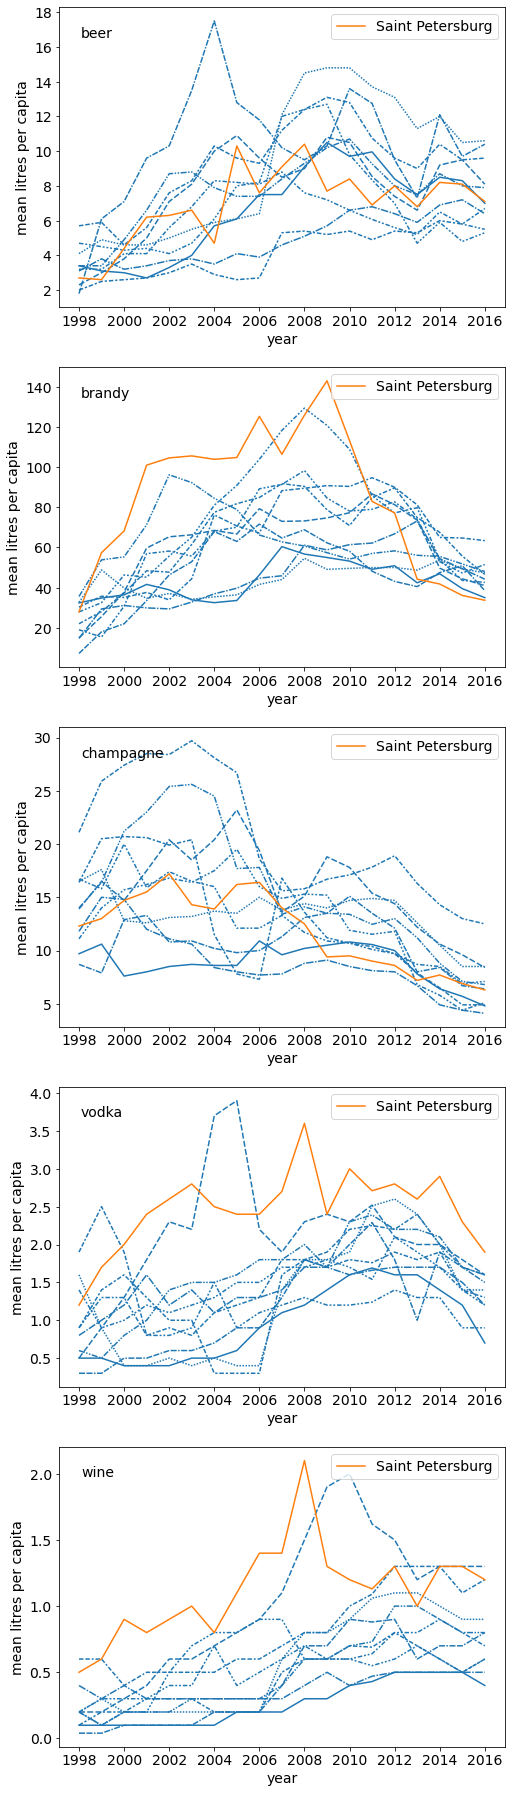

In [241]:
beverages = ['wine', 'beer', 'vodka', 'champagne', 'brandy']
fig, ax = plt.subplots(5, 1, figsize=(8, 32))
for i in range(len(beverages)):
    sns.lineplot(data=df.query('region != "Saint Petersburg" and region in @chosen_regions'), 
                 x='year', y=beverages[i], ax=ax[i], 
                 style='region', legend=False)
    sns.lineplot(data=df.query('region == "Saint Petersburg"'), 
                 x='year', y=beverages[i], ax=ax[i], label='Saint Petersburg', )
    ax[i].set_xticks(range(1998, 2017, 2))
    ax[i].text(0.05, 0.9, columns_to_plot[i], fontsize=14, transform=ax[i].transAxes)
    ax[i].set_ylabel('mean litres per capita')
    ax[i].legend(loc='upper right')

In analyzing the result we should remember that we chose the regions that were close to Saint Petersburg in consumption in 2014-2016.

But anyway, the consumption is close, so we were able to find the 10 closest regions to Saint Petersburg.

## Conclusions

In this project we performed the alcohol consumption habit analysis in Russia, so that we could offer the marketing team the regions that are close in their habits to Saint Petersburg. In order to do so, we:
- Made an EDA of our dataset, which showed us that Saint Petersburg alcohol consumption differs for some beverages from the national consumption.
- Performed data preprocessing, where we limited our dataset to only recent years from 2014 to 2016 and removed the regions where there were not enough info on the consumption.
- Conducted feature engineering, and for each beverage created the features: mean consumption, standart deviation of the consumption, overall consumption, 2016 consumption and the trend of the consumption.
- Reduced our dimensionality from 25 to 10 features and showed that it can explain 95% variance of the data.
- Found the nearest neighbours to Saint Petersburg by calculating the Euclidian distance from each region to the region of interested. After that, we extracted only 10 closest regions:
    - Novgorod Oblast
    - Smolensk Oblast
    - Chelyabinsk Oblast
    - Leningrad Oblast
    - Bryansk Oblast
    - Perm Krai
    - Oryol Oblast
    - Novosibirsk Oblast
    - Pskov Oblast
    - Komi Republic
- Visualisation of the results showed that indeed we were able to find regions that are close not only in our reduced dimensionality space, but also in alcohol consumption in the original dataframe.